In [1]:
from Bio import Entrez
import requests
import re
import pandas as pd
import time

# Set your email for NCBI Entrez
Entrez.email = "your.email@example.com"

# Step 1: Search ClinVar for EGFR missense variants
def search_egfr_clinvar_ids():
    handle = Entrez.esearch(
        db="clinvar",
        term='"EGFR"[gene] AND missense_variant[clinical_variant]',
        retmax=10000
    )
    record = Entrez.read(handle)
    handle.close()
    return record['IdList']

# Step 2: Fetch ClinVar variant summaries
def fetch_variant_summaries(id_list, batch_size=100, sleep_time=0.4):
    summaries = []

    for i in range(0, len(id_list), batch_size):
        print(f"fetch variant batch by batch: batch: {i}.")
        batch_ids = id_list[i:i + batch_size]
        ids_str = ",".join(batch_ids)
        url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=clinvar&id={ids_str}&retmode=json"

        try:
            response = requests.get(url, timeout=20)
            response.raise_for_status()
            data = response.json()
            result_set = data.get('result', {})
            for vid in batch_ids:
                doc = result_set.get(vid)
                if doc:
                    hgvs = doc.get('title', '')
                    clinical_sig = ','.join(doc.get('clinical_significance', {}).get('description', []))
                    summaries.append((vid, hgvs, clinical_sig))
        except Exception as e:
            print(f"Error processing batch {i}-{i+batch_size}: {e}")

        time.sleep(sleep_time)  # Respect NCBI rate limits

    return summaries
'''    
def fetch_variant_summaries(id_list):
    summaries = []
    for vid in id_list:
        url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=clinvar&id={vid}&retmode=json"
        response = requests.get(url)
        if response.ok:
            data = response.json()
            doc = data['result'].get(vid)
            if doc:
                hgvs = doc.get('title', '')
                clinical_sig = ','.join(doc.get('clinical_significance', {}).get('description', []))
                summaries.append((vid, hgvs, clinical_sig))
    return summaries
'''
# Step 3: Filter for TKD domain positions (amino acids 688–875)
def filter_egfr_missense(summaries):
    egfr_variants = []
    pattern = re.compile(r'p\.([A-Z][a-z]{2})(\d+)([A-Z][a-z]{2})')
    for vid, hgvs, sig in summaries:
        match = pattern.search(hgvs)
        #print(match)
        if match:
            from_aa = match.group(1)
            pos = int(match.group(2))
            to_aa = match.group(3)
            
            egfr_variants.append({
                    "ClinVar_ID": vid,
                    "HGVS": hgvs,
                    "From_AA": from_aa,
                    "Position": pos,
                    "To_AA": to_aa,
                    "Clinical_Significance": sig
            })
            '''    
            if 688 <= pos <= 875:
                tkd_variants.append({
                    "ClinVar_ID": vid,
                    "HGVS": hgvs,
                    "From_AA": from_aa,
                    "Position": pos,
                    "To_AA": to_aa,
                    "Clinical_Significance": sig
                })
            ''' 
    columns = ["ClinVar_ID", "HGVS", "From_AA", "Position", "To_AA", "Clinical_Significance"]
    return pd.DataFrame(egfr_variants, columns=columns)

# Run the pipeline
if __name__ == "__main__":
    ids = search_egfr_clinvar_ids()
    print(f"Found {len(ids)} ClinVar entries for EGFR missense variants.")
    summaries = fetch_variant_summaries(ids)
    #summaries = fetch_variant_summaries(ids)
    egfr_variants = filter_egfr_missense(summaries)
    print(egfr_variants)
    egfr_variants.to_csv("EGFR_missense_variants.csv", index=False)
    
    '''
    print("\nEGFR TKD Missense Variants from ClinVar:")
    print("-----------------------------------------------------------")
    for vid, hgvs, sig in tkd_variants:
        print(f"ID: {vid}\tHGVS: {hgvs}\tClinical Significance: {sig}")
    '''

Found 1645 ClinVar entries for EGFR missense variants.
fetch variant batch by batch: batch: 0.
fetch variant batch by batch: batch: 100.
fetch variant batch by batch: batch: 200.
fetch variant batch by batch: batch: 300.
fetch variant batch by batch: batch: 400.
fetch variant batch by batch: batch: 500.
fetch variant batch by batch: batch: 600.
fetch variant batch by batch: batch: 700.
fetch variant batch by batch: batch: 800.
fetch variant batch by batch: batch: 900.
fetch variant batch by batch: batch: 1000.
fetch variant batch by batch: batch: 1100.
fetch variant batch by batch: batch: 1200.
fetch variant batch by batch: batch: 1300.
fetch variant batch by batch: batch: 1400.
fetch variant batch by batch: batch: 1500.
fetch variant batch by batch: batch: 1600.
     ClinVar_ID                                       HGVS From_AA  Position  \
0       4016819   NM_005228.5(EGFR):c.994C>A (p.Pro332Thr)     Pro       332   
1       4016818  NM_005228.5(EGFR):c.2470G>C (p.Gly824Arg)     Gly

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Load your variant data
df = pd.read_csv("EGFR_missense_variants.csv")  # must have a 'Position' column
#df['short_HGVS']=df['From_AA'].astype(str)+df['Position'].astype(str)+df['To_AA'].astype(str)
#print(df['short_HGVS'].value_counts())
#print(df['short_HGVS'].duplicated())

# Define protein length (EGFR = 1210), and domain region(s)
PROTEIN_LENGTH = 1210
TKD_START = 712
TKD_END = 978
, 
# Hotspot analysis: count mutations per residue
counts = df['Position'].value_counts().sort_index()
residue_range = np.arange(1, PROTEIN_LENGTH + 1)
mutation_counts = pd.Series(0, index=residue_range)
mutation_counts.update(counts)

# Domain mutation count
domain_mutations = mutation_counts[TKD_START:TKD_END + 1].sum()
non_domain_mutations = mutation_counts.sum() - domain_mutations

# Domain size
domain_length = TKD_END - TKD_START + 1
non_domain_length = PROTEIN_LENGTH - domain_length

# Enrichment analysis: chi-squared test
contingency_table = np.array([
    [domain_mutations, domain_length],
    [non_domain_mutations, non_domain_length]
])
chi2, p, _, _ = chi2_contingency(contingency_table)

# Output result
print("=== Domain Enrichment Analysis ===")
print(f"TKD Mutation Count: {domain_mutations}")
print(f"Non-TKD Mutation Count: {non_domain_mutations}")
print(f"Chi-squared test p-value: {p:.5f}")
if p < 0.05:
    print("Mutations are significantly enriched in TKD.")
else:
    print("No significant enrichment detected.")


=== Domain Enrichment Analysis ===
TKD Mutation Count: 361
Non-TKD Mutation Count: 1263
Chi-squared test p-value: 0.95407
No significant enrichment detected.


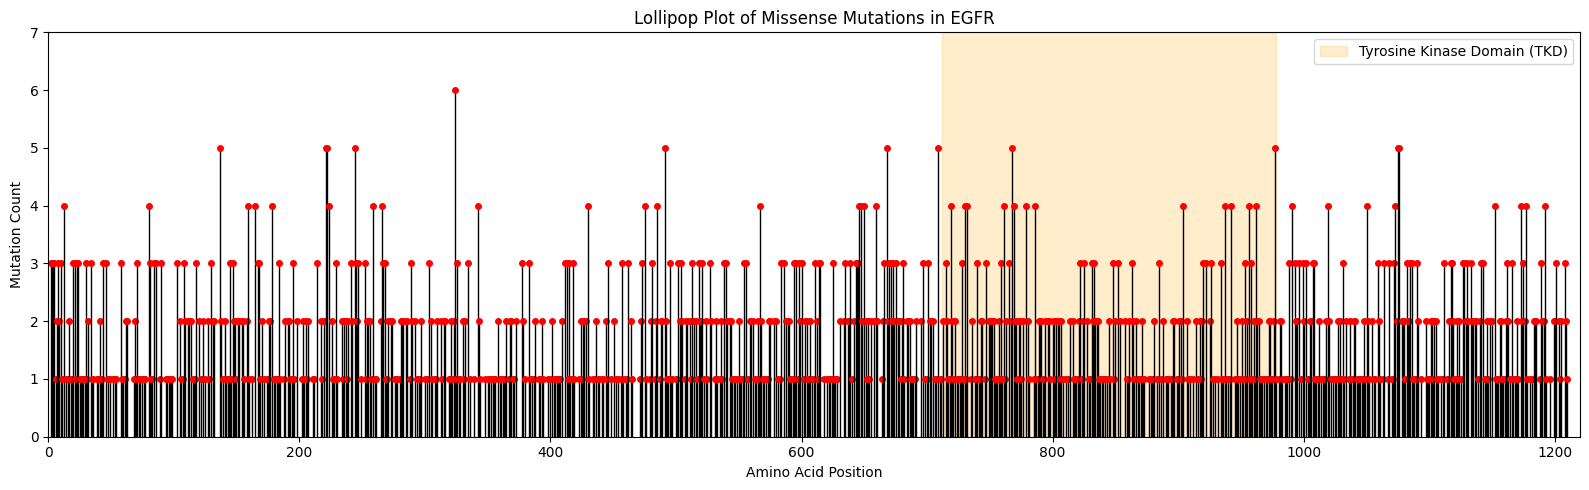

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Example input: mutation positions (can be from ClinVar summaries)
# You may already have this as a DataFrame


# Count mutations per residue
mutation_counts = df["Position"].value_counts().sort_index()

# Protein size (EGFR = 1210 residues)
protein_length = 1210
positions = list(range(1, protein_length + 1))
counts = [mutation_counts.get(pos, 0) for pos in positions]

# TKD range
TKD_START, TKD_END = 712, 978

# Plot
plt.figure(figsize=(16, 5))
ax = plt.gca()

# Draw lollipops
for pos, count in zip(positions, counts):
    if count > 0:
        ax.vlines(pos, 0, count, color="black", linewidth=1)
        ax.plot(pos, count, "o", color="red", markersize=4)

# TKD domain highlight
ax.axvspan(TKD_START, TKD_END, color="orange", alpha=0.2, label="Tyrosine Kinase Domain (TKD)")

# Labels
plt.xlabel("Amino Acid Position")
plt.ylabel("Mutation Count")
plt.title("Lollipop Plot of Missense Mutations in EGFR")
plt.xlim(0, protein_length + 10)
plt.ylim(0, max(counts) + 1)
plt.legend()
plt.tight_layout()

# Save or show
plt.savefig("egfr_lollipop_plot.png", dpi=300)
plt.show()


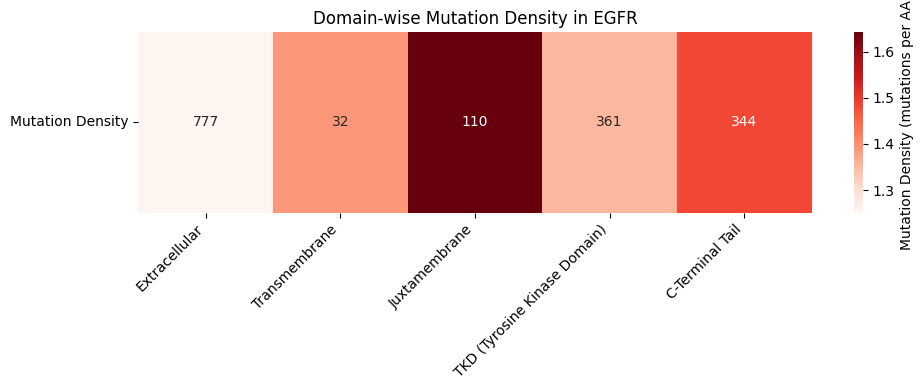

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load variant data (must have Position column)


# Define protein domains (you can refine these with UniProt annotations)
domains = {
    "Extracellular": (1, 621),
    "Transmembrane": (622, 644),
    "Juxtamembrane": (645, 711),
    "TKD (Tyrosine Kinase Domain)": (712, 978),
    "C-Terminal Tail": (979, 1210),
}

# Count mutations per domain
domain_counts = {}
total_mutations = len(df)

for name, (start, end) in domains.items():
    count = df[(df["Position"] >= start) & (df["Position"] <= end)].shape[0]
    length = end - start + 1
    density = count / length  # mutations per residue
    domain_counts[name] = {
        "Mutations": count,
        "Length": length,
        "Density": density
    }

# Convert to DataFrame for plotting
domain_df = pd.DataFrame.from_dict(domain_counts, orient="index")
domain_df = domain_df.reset_index().rename(columns={"index": "Domain"})

# Plot as heatmap bar
plt.figure(figsize=(10, 4))
heat = sns.heatmap(
    domain_df[["Density"]].T,
    cmap="Reds",
    annot=domain_df["Mutations"].values.reshape(1, -1),
    fmt="d",
    cbar_kws={'label': 'Mutation Density (mutations per AA)'}
)

# Aesthetic tweaks
heat.set_xticklabels(domain_df["Domain"], rotation=45, ha="right")
heat.set_yticklabels(["Mutation Density"], rotation=0)
plt.title("Domain-wise Mutation Density in EGFR")
plt.tight_layout()
plt.savefig("egfr_domain_mutation_heatmap.png", dpi=300)
plt.show()


In [5]:
df_tkd = df[(df['Position'] >= 712) & (df['Position'] <=978)].copy()
df_tkd.to_csv("EGFR_TKD_missense_variants.csv", index=False)

In [6]:
# Split into 3 parts
def split_variant(s):
    part1, rest = s.split(":", 1)  # split once at the first ":"
    
    # extract nucleotide change (starts with c.)
    match_c = re.search(r"(c\.[^ ]+)", rest)
    part2 = match_c.group(1) if match_c else None

    # extract protein change inside parentheses
    match_p = re.search(r"\(p\.([A-Za-z0-9]+)\)", rest)
    part3 = f"p.{match_p.group(1)}" if match_p else None

    return pd.Series([part1, part2, part3])


In [7]:
df[['Transcript', 'HGVS_cDNA', 'HGVSp']] = df['HGVS'].apply(split_variant)
df

,ClinVar_ID,HGVS,From_AA,Position,To_AA,Clinical_Significance,Transcript,HGVS_cDNA,HGVSp
0,4016819,NM_005228.5(EGFR):c.994C>A (p.Pro332Thr),Pro,332,Thr,NaN,NM_005228.5(EGFR),c.994C>A,p.Pro332Thr
1,4016818,NM_005228.5(EGFR):c.2470G>C (p.Gly824Arg),Gly,824,Arg,NaN,NM_005228.5(EGFR),c.2470G>C,p.Gly824Arg
2,4016812,NM_005228.5(EGFR):c.230C>T (p.Ser77Phe),Ser,77,Phe,NaN,NM_005228.5(EGFR),c.230C>T,p.Ser77Phe
3,4016811,NM_005228.5(EGFR):c.566A>C (p.Lys189Thr),Lys,189,Thr,NaN,NM_005228.5(EGFR),c.566A>C,p.Lys189Thr
4,4016807,NM_005228.5(EGFR):c.2356G>C (p.Val786Leu),Val,786,Leu,NaN,NM_005228.5(EGFR),c.2356G>C,p.Val786Leu
...,...,...,...,...,...,...,...,...,...
1619,45217,NM_005228.5(EGFR):c.2065G>C (p.Val689Leu),Val,689,Leu,NaN,NM_005228.5(EGFR),c.2065G>C,p.Val689Leu
1620,16613,NM_005228.5(EGFR):c.2369C>T (p.Thr790Met),Thr,790,Met,NaN,NM_005228.5(EGFR),c.2369C>T,p.Thr790Met
1621,16612,NM_005228.5(EGFR):c.2155G>A (p.Gly719Ser),Gly,719,Ser,NaN,NM_005228.5(EGFR),c.2155G>A,p.Gly719Ser
1622,16611,NM_005228.5(EGFR):c.2155G>T (p.Gly719Cys),Gly,719,Cys,NaN,NM_005228.5(EGFR),c.2155G>T,p.Gly719Cys


In [8]:
from Bio import Entrez, SeqIO

Entrez.email = "your.email@example.com"
handle = Entrez.efetch(db="protein", id="NP_005219", rettype="fasta", retmode="text")
record = SeqIO.read(handle, "fasta")
print("Full EGFR sequence length:", len(record.seq))
print("TKD region (aa 712-978):")
print(record.seq[712:978])

Full EGFR sequence length: 1210
TKD region (aa 712-978):
KKIKVLGSGAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGICLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAARNVLVKTPQHVKITDFGLAKLLGAEEKEYHAEGGKVPIKWMALESILHRIYTHQSDVWSYGVTVWELMTFGSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPKFRELIIEFSKMARDPQRY


In [9]:
import re
# 3-letter to 1-letter amino acid mapping
aa_three_to_one = {
    'Ala': 'A', 'Arg': 'R', 'Asn': 'N', 'Asp': 'D', 'Cys': 'C',
    'Gln': 'Q', 'Glu': 'E', 'Gly': 'G', 'His': 'H', 'Ile': 'I',
    'Leu': 'L', 'Lys': 'K', 'Met': 'M', 'Phe': 'F', 'Pro': 'P',
    'Ser': 'S', 'Thr': 'T', 'Trp': 'W', 'Tyr': 'Y', 'Val': 'V',
    'Ter': '*'
}

def parse_hgvsp(hgvsp):
    if not isinstance(hgvsp, str) or not hgvsp.startswith('p.'):
        return {'type': None}
    parse_list = []
    m = re.match(r'p\.([A-Z][a-z]{2})(\d+)([A-Z][a-z]{2})$', hgvsp)
    if m:

        return {
            'type': 'substitution',
            'ref': aa_three_to_one.get(m.group(1)),
            'pos': int(m.group(2)),
            'alt': aa_three_to_one.get(m.group(3))
        }

def mutate_protein(seq, mutation):

    if not seq or mutation['type'] == 'unknown':
        return None

    seq_list = list(seq)

    if mutation['type'] == 'substitution':
        pos = mutation['pos'] - 1
        if seq_list[pos] != mutation['ref']:
            print(f"Warning: expected {mutation['ref']} at {pos+1}, found {seq_list[pos]}")
        seq_list[pos] = mutation['alt']
        #print(mutation['ref'], pos, mutation['alt'])

    return ''.join(seq_list)

In [11]:
df['Protein_Sequence'] = f"{record.seq}"
#print(df)
# Parse mutations
df['Mutation_Info'] = df['HGVSp'].apply(parse_hgvsp)
# Apply mutations
df['Mutated_Protein_Sequence'] = df.apply(
    lambda row: mutate_protein(row['Protein_Sequence'], row['Mutation_Info']), axis=1
)


In [12]:
print(df)

      ClinVar_ID                                       HGVS From_AA  Position  \
0        4016819   NM_005228.5(EGFR):c.994C>A (p.Pro332Thr)     Pro       332   
1        4016818  NM_005228.5(EGFR):c.2470G>C (p.Gly824Arg)     Gly       824   
2        4016812    NM_005228.5(EGFR):c.230C>T (p.Ser77Phe)     Ser        77   
3        4016811   NM_005228.5(EGFR):c.566A>C (p.Lys189Thr)     Lys       189   
4        4016807  NM_005228.5(EGFR):c.2356G>C (p.Val786Leu)     Val       786   
...          ...                                        ...     ...       ...   
1619       45217  NM_005228.5(EGFR):c.2065G>C (p.Val689Leu)     Val       689   
1620       16613  NM_005228.5(EGFR):c.2369C>T (p.Thr790Met)     Thr       790   
1621       16612  NM_005228.5(EGFR):c.2155G>A (p.Gly719Ser)     Gly       719   
1622       16611  NM_005228.5(EGFR):c.2155G>T (p.Gly719Cys)     Gly       719   
1623       16609  NM_005228.5(EGFR):c.2573T>G (p.Leu858Arg)     Leu       858   

     To_AA  Clinical_Signif

In [14]:
from pathlib import Path
# Save to multi-FASTA
def to_fasta(row):
    ini_pos, end_pos = 712, 978
    mut = row['Mutation_Info']
    if not row['Mutated_Protein_Sequence']:
        return None
    # build header
    parts = [
        str(row['ClinVar_ID']),
        row['HGVSp'],
        f"type:{mut.get('type')}"
    ]
    if 'pos' in mut:
        parts.append(f"pos:{mut['pos']}")
        if mut['pos'] >= ini_pos and mut['pos'] <= end_pos:
            header = ">" + "|".join(parts)

            sequence = row['Mutated_Protein_Sequence'][ini_pos-1:end_pos]
            #wrapped = "\n".join(sequence[i:i+60] for i in range(0, len(sequence), 60))
            #return f"{header}\n{wrapped}"
            return f"{header}\n{sequence}"

fasta_entries = df.apply(to_fasta, axis=1).dropna().tolist()
output_fasta = Path("mutated_tkd_proteins.fasta")
with open(output_fasta, 'w') as f:
    f.write("\n".join(fasta_entries))